In [1]:
import random
import numpy as np
import torch
import os
import pathlib
import pickle
from gurobipy import *
from rsome import ro
from rsome import grb_solver as grb
import rsome as rso
from rsome import cpt_solver as cpt

In [ ]:
# data_generation_process = "SPO_Data_Generation"
data_generation_process = "DDR_Data_Generation"

# Parameters

In [3]:
# import pyepo
# generate data
grid = (5,5) # grid size
num_train = 50 # number of training data
num_feat = 5 # size of feature
num_test = 1000
deg = 1.2 # polynomial degree
e = 10 # scale of normal std or the range of uniform. For the error term

lower = 0 # coef lower bound
upper = 1 # coef upper bound
p = num_feat # num of features
d = (grid[0] - 1) * (grid[0] - 1) * 2 + 2 * (grid[0] - 1) # num of arcs
alpha = e # scale of normal std or the range of uniform. For the error term
mis = deg # model misspecification
coef_seed = 1

In [19]:
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
grandparent_directory = os.path.dirname(parent_directory)
DataPath = os.path.dirname(grandparent_directory) + '/Data/Test0325_' + data_generation_process + "/"
pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)
print("grandparent_directory:", grandparent_directory)
print("DataPath:", DataPath)
DataPath = DataPath + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_coef_seed="+str(coef_seed)+"/"
pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)

grandparent_directory: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Code_MacBook
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Test0325_DDR_Data_Generation/


# Generate Data

In [5]:
def Prepare_Data(DataPath,lower, upper, p, d, coef_seed,seed_all,num_test, num_train, alpha,mis,data_generation_process):
# #  ****** Coef generation *********
    from Data import data_generation
    data_gen = data_generation()
    # print("W_star = ",W_star[0,:])
    W_star = data_gen.generate_truth(DataPath,lower, upper, p, d, coef_seed,version = 0) 

    x_test_all = {}; c_test_all = {}; x_train_all = {}; c_train_all = {}; W_star_all = {}
    for seed in seed_all:
        DataPath_seed = DataPath +"Seed="+str(seed)+"/"
        pathlib.Path(DataPath_seed).mkdir(parents=True, exist_ok=True)
        # #  ****** Data generation *********
        x_test_all[seed], c_test_all[seed], x_train_all[seed], c_train_all[seed], W_star_all[seed] = data_gen.generate_samples(seed,DataPath_seed,p, d, num_test, num_train, alpha, W_star, mis, thres = 10, 
                                version = data_generation_process, x_dist = 'normal', e_dist = 'normal', x_low = 0, x_up = 2, x_mean = 2, x_var = 0.25, bump = 100) 
        # print()
    return x_test_all, c_test_all, x_train_all, c_train_all, W_star_all

# EPO(SPO+,...)

In [6]:
# from PYEPO import PyEPO_Method
# epo_runner = PyEPO_Method()
def Implement_EPO(DataPath,seed_all,batch_size,num_epochs,method_names,x_train_all,c_train_all,x_test_all,c_test_all,arcs,epo_runner):
    cost_EPO = {}
    # batch_size = 20
    # num_epochs = 30
    for seed in seed_all:
        DataPath_seed = DataPath +"Seed="+str(seed)+"/"
        pathlib.Path(DataPath_seed).mkdir(parents=True, exist_ok=True)
        print("*** seed = ",seed,": Run EPO ******")
        cost_EPO[seed] = epo_runner.run(method_names,DataPath_seed,batch_size,num_feat,grid,num_epochs,\
                                        x_train_all[seed],c_train_all[seed],x_test_all[seed],c_test_all[seed],arcs)
    return cost_EPO

# Obtain DDR estimation

### define network

In [7]:
def _getArcs(grid):
    arcs = []
    for i in range(grid[0]):
        # edges on rows
        for j in range(grid[1] - 1):
            v = i * grid[1] + j
            arcs.append((v, v + 1))
        # edges in columns
        if i == grid[0] - 1:
            continue
        for j in range(grid[1]):
            v = i * grid[1] + j
            arcs.append((v, v + grid[1]))

    arc_index_mapping = {}
    for i in range(len(arcs)):
        arc = arcs[i]
        arc_index_mapping[arc] = i

    return arcs,arc_index_mapping

In [8]:
def solve_DDR(arcs,lamb,mu_fixed,num_nodes,x_train,c_train):
    
    N,p = x_train.shape
    N,d = c_train.shape

    # DDR
    m = Model("ddr")
    #m.setParam("DualReductions",0)
    m.setParam('OutputFlag', 0)

    W_ind = tuplelist( [(i,j) for i in range(d) for j in range(p)] )
    w0_ind = tuplelist( [i for i in range(d)])

    W_ddr = m.addVars(W_ind, lb=-GRB.INFINITY,name = "W" )
    w0_ddr = m.addVars(w0_ind, lb=-GRB.INFINITY,name = "W0" )
    alpha = m.addVars(N,num_nodes,lb=-GRB.INFINITY,name="alpha")
    expr_obj = 0
    err = []
    for n in range(N):
        cost_true_tem = c_train[n]
        expr_obj = expr_obj + alpha[n,num_nodes-1] - alpha[n,0]
        for ind in range(len(arcs)):
            cost_pred_tem = quicksum([W_ddr[ind,j] * x_train[n,j] for j in range(p)]) + w0_ddr[ind]
            err.append(cost_true_tem[ind] - cost_pred_tem)
            e = arcs[ind]
            j = e[1]
            i = e[0]
            # print("j = ",j,", i = ",i, ", e = ",e)
            m.addConstr(alpha[n,j] - alpha[n,i] >= -mu_fixed*cost_true_tem[ind] - (1-mu_fixed)*cost_pred_tem)

    m.setObjective(quicksum([err[k] * err[k] for k in range(len(err))])/N + lamb*(expr_obj)/N, GRB.MINIMIZE)
    m.optimize()
    
    W_DDR_rst = m.getAttr('x', W_ddr)
    w0_DDR_rst = m.getAttr('x', w0_ddr)
    W_ddr_val = []
    for i in range(d):
        W_ddr_val.append([W_DDR_rst[(i,j)] for j in range(p)])
    w0_ddr_val = [w0_DDR_rst[i] for i in range(d)]

    alpha_rst = m.getAttr('x', alpha)
    return w0_ddr_val,W_ddr_val,alpha_rst,m.ObjVal

# Out-of-sample performance

### Generate data

In [9]:
arcs,arc_index_mapping = _getArcs(grid)
num_arcs = len(arcs)
seed_all = np.arange(1,100)
# obtain data
x_test_all, c_test_all, x_train_all, c_train_all, W_star_all = Prepare_Data(DataPath,lower, upper, p, d, coef_seed,seed_all,num_test, num_train, alpha,mis,data_generation_process)

### EPO performance

In [10]:
# EPO, including SPO, PG, LTR
batch_size = 20
num_epochs = 30
method_names = ["spo+","pg","ltr"]

from PYEPO import PyEPO_Method
epo_runner = PyEPO_Method()
cost_EPO_all = Implement_EPO(DataPath,[1],batch_size,num_epochs,method_names,x_train_all,c_train_all,x_test_all,c_test_all,arcs,epo_runner)
# OLS

*** seed =  1 : Run EPO ******
Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-13
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 2076.33it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 3386.77it/s]

=========== Run SPO =============


Num of cores: 2
=========== Run PG =============
Num of cores: 2
=========== Run LTR =============
Num of cores: 2


### OLS performance

In [11]:
from OLS import ols_method
ols_method_obj = ols_method()
from Peformance import performance_evaluation
perfs = performance_evaluation()
W_ols_all = {}; w0_ols_all = {}; t_ols_all = {}; obj_ols_all = {}
cost_OLS_all = {}; cost_Oracle_all = {}

for seed in seed_all:
    # compute OLS performance
    W_ols_all[seed], w0_ols_all[seed], t_ols_all[seed], obj_ols_all[seed] = ols_method_obj.ols_solver("",x_train_all[seed], c_train_all[seed])
    cost_OLS_all[seed] = perfs.compute_Cost_with_Prediction(arcs,w0_ols_all[seed],W_ols_all[seed], grid,c_test_all[seed],x_test_all[seed])
    cost_Oracle_all[seed] = perfs.compute_Oracel_Cost(arcs, grid,c_test_all[seed])

### DDR performance

In [12]:
def obtain_DDR_out_of_sample_performance(mu,lamb_all,num_nodes,x_train,c_train,x_test,c_test,cost_OLS,cost_Oracle,perfs):

    regret_arr = np.zeros(len(lamb_all))
    lamb_index = 0
    cost_DDR = {}
    for lamb in lamb_all:
        w0_ddr_val,W_ddr_val,alpha_rst,obj_ddr = solve_DDR(arcs,lamb,mu,num_nodes,x_train,c_train)
        cost_DDR[lamb] = perfs.compute_Cost_with_Prediction(arcs,w0_ddr_val,W_ddr_val, grid,c_test,x_test)
        regret_arr[lamb_index] = (np.nanmean(cost_OLS) - np.nanmean(cost_DDR[lamb]) )/(np.nanmean(cost_OLS) - np.nanmean(cost_Oracle)) * 100
        lamb_index = lamb_index + 1
        # print("seed=",seed,",mu=",mu_fixed,",lamb=",lamb,",obj_ddr=",obj_ddr,",regret=",regret_arr[lamb_index])
    return regret_arr,cost_DDR

In [13]:
num_nodes = grid[0]*grid[0]
mu = 0.9
lamb_all = np.round(np.arange(0.1,1.0,0.1),2)
regret_all = {}; cost_DDR_all = {}
for seed in seed_all:
    regret_all[seed,mu],cost_DDR_all[seed,mu] = obtain_DDR_out_of_sample_performance(mu,lamb_all,num_nodes,x_train_all[seed],c_train_all[seed],x_test_all[seed],c_test_all[seed],cost_OLS_all[seed],cost_Oracle_all[seed],perfs)
    print("seed=",seed,",mu=",mu,"regret=",np.round(regret_all[seed,mu],4))

seed= 1 ,mu= 0.9 regret= [0.     0.0992 0.0992 0.3358 0.3822 0.3822 0.3729 0.3729 0.3729]
seed= 2 ,mu= 0.9 regret= [0. 0. 0. 0. 0. 0. 0. 0. 0.]
seed= 3 ,mu= 0.9 regret= [ 0.      0.0367  0.0367  0.0367 -0.191  -0.191  -0.191  -0.191   0.0984]
seed= 4 ,mu= 0.9 regret= [ 0.    0.    0.    0.    0.    0.    0.   -0.17 -0.17]
seed= 5 ,mu= 0.9 regret= [0.     0.     0.1111 0.1111 0.1111 0.1111 0.1111 0.2178 0.2178]
seed= 6 ,mu= 0.9 regret= [0.1569 0.2036 0.2124 0.3224 0.1185 0.1185 0.1185 0.1185 0.1185]
seed= 7 ,mu= 0.9 regret= [ 0.      0.      0.      0.     -0.0039 -0.0039 -0.2421 -0.2421 -0.2421]
seed= 8 ,mu= 0.9 regret= [0.    0.    0.119 0.119 0.119 0.119 0.119 0.119 0.119]
seed= 9 ,mu= 0.9 regret= [ 0.     -0.0721 -0.0721 -0.0721  0.1162 -0.1257 -0.3414 -0.5126 -0.5126]
seed= 10 ,mu= 0.9 regret= [-0.1699 -0.3608 -0.5473 -0.5473 -0.6858 -0.6858 -0.6858 -0.6858 -0.8414]
seed= 11 ,mu= 0.9 regret= [ 0.      0.     -0.3826 -0.4695 -0.2907 -0.2907 -0.4047 -0.5769 -0.5769]
seed= 12 ,mu= 0.9

In [14]:
regret_avg = np.zeros(len(lamb_all))
for seed in seed_all:
    regret_avg = regret_avg + regret_all[seed,mu]
regret_avg = regret_avg/(len(seed_all))
print("regret_avg=",np.round(regret_avg,4))

regret_avg= [-0.0117 -0.0364 -0.034  -0.0268 -0.0254 -0.0313 -0.0352 -0.0516 -0.065 ]


In [15]:
np.shape(cost_DDR_all[seed,mu][0.2])

(1000,)

# Plot figures

In [16]:
def cross_compare2plus(c_item, c_base, c_oracle):
    c_item = np.asarray(c_item)
    c_base = np.asarray(c_base)
    c_oracle = np.asarray(c_oracle)

    N = len(c_item)
    c_diff = c_item - c_base
    lbel = np.zeros((N,1))
    
    equals = np.sum(c_diff == 0)
    wins = np.sum(c_diff < 0)
    lose = np.sum(c_diff > 0)
    
    lbel[c_diff < 0] = 1
    lbel[c_diff > 0] = -1
    
    # print("Num_train =",N,",Num_equals =",equals,",Num_wins =",wins,",Num_lose =",lose)
    # print("base cost = ", np.mean(c_base),",item cost = ",np.mean(c_item))
    if N == equals:
        win_ratio = 0.5
    else:
        win_ratio = wins/(N - equals)
    # cost_reduction = (np.mean(c_base) - np.mean(c_item) )/np.abs(np.mean(c_oracle))
    regret_reduction = (np.nanmean(c_base) - np.nanmean(c_item))/np.abs(np.nanmean(c_base) - np.nanmean(c_oracle))
    return lbel, win_ratio, regret_reduction

In [17]:
mu = 0.9
H2H_DDR_vs_OLS_all = {}; regret_reduction_DDR_vs_OLS_all = {}
for lamb in lamb_all:
    H2H_DDR_vs_OLS_arr = np.zeros(len(seed_all)); regret_reduction_DDR_vs_OLS_arr = np.zeros(len(seed_all))
    seed_index = 0
    print("lamb = ",lamb)
    for seed in seed_all:
        lbel, H2H_DDR_vs_OLS_arr[seed_index], H2H_DDR_vs_OLS_arr[seed_index] = cross_compare2plus(cost_DDR_all[seed,mu][lamb],cost_OLS_all[seed], cost_Oracle_all[seed])
        seed_index = seed_index + 1
    H2H_DDR_vs_OLS_all[mu,lamb] = H2H_DDR_vs_OLS_arr; regret_reduction_DDR_vs_OLS_all[mu,lamb] = H2H_DDR_vs_OLS_arr

lamb =  0.1
lamb =  0.2
lamb =  0.3
lamb =  0.4
lamb =  0.5
lamb =  0.6
lamb =  0.7
lamb =  0.8
lamb =  0.9


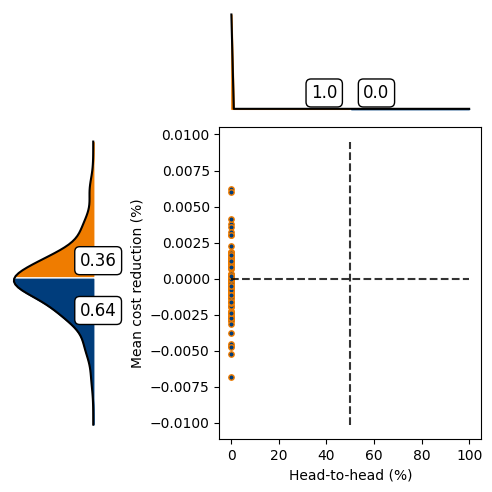

In [18]:
mu = 0.9
lamb = 0.5
import Figures
Figures.figure_plot_upleft(H2H_DDR_vs_OLS_all[mu,lamb], regret_reduction_DDR_vs_OLS_all[mu,lamb], "", size = (5, 5), move = [-0.12, 0.04, 0.35, 0.55], 
                    ysame = 0, yrange = [6,6], sublabel = '', ypio = 0)